In [1]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices=True

from matplotlib import pyplot as plt

from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

from openmm import unit, app, LangevinIntegrator

# Demonstration of how to use SerenityFF as an OpenFF plugin for a Simulation

### Create the ForceField object

Since SerenityFF only changes the partial charges of the system we need a OpenFF file as a base. In this repository a modified version is included. The only modification is that the `Electrostatics` handler is set to `SerenityFF`. To load the Forcefield correctly `load_plugins=True` has to be set, and the SerenityFF package has to be installed properly, which should link the plugin to the ForceField object.

In [2]:
ff_path = "../data/openff-2.0.0-serenity.offxml"

In [3]:
ff = ForceField(ff_path, load_plugins=True)

Loading DASH tree data


### Create a openff molecule

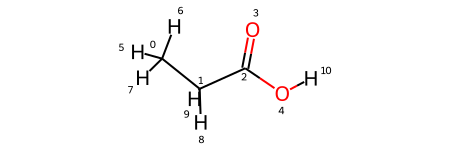

In [4]:
rdkit_mol = Chem.MolFromSmiles("CCC(=O)O")
rdkit_mol = Chem.AddHs(rdkit_mol)
AllChem.EmbedMolecule(rdkit_mol)
rdkit_mol

In [5]:
molecule = Molecule.from_rdkit(rdkit_mol)
topology = Topology.from_molecules(molecule)

In [6]:
partial_charges = ff.get_partial_charges(molecule=molecule)
partial_charges = partial_charges.value_in_unit(partial_charges.unit)
print(partial_charges)

<class 'openff.toolkit.topology.topology.TopologyMolecule'>
Assigned partial charges: [-0.41811164 -0.22355267  0.74462508 -0.62782736 -0.61791253  0.13756528
  0.13756528  0.13756528  0.11586904  0.11586904  0.4983452 ] e
[-0.41811164 -0.22355267  0.74462508 -0.62782736 -0.61791253  0.13756528
  0.13756528  0.13756528  0.11586904  0.11586904  0.4983452 ]


### Create a openmm system

In [7]:
openmm_system = ff.create_openmm_system(topology)

<class 'openff.toolkit.topology.topology.TopologyMolecule'>
Assigned partial charges: [-0.41811164 -0.22355267  0.74462508 -0.62782736 -0.61791253  0.13756528
  0.13756528  0.13756528  0.11586904  0.11586904  0.4983452 ] e


In [8]:
integrator = LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 4 * unit.femtosecond)

In [9]:
simulation = app.Simulation(topology.to_openmm(), openmm_system, integrator)

In [10]:
simulation.context.setPositions(molecule.conformers[0])

In [11]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)

In [12]:
simulation.reporters.append(app.StateDataReporter("./example_openmm.csv", 10, step=True, potentialEnergy=True, temperature=True))

### run a simulation

In [13]:
simulation.step(100)

In [14]:
df_openmm = pd.read_csv("./example_openmm.csv")

In [15]:
df_openmm

,"#""Step""",Potential Energy (kJ/mole),Temperature (K)
0,10,-3.095535,319.574303
1,20,-11.686798,363.860958
2,30,-25.844940,431.928626
3,40,-30.044540,417.098955
4,50,-34.600754,387.794719
5,60,-35.055359,418.931913
6,70,-14.177765,313.354309
7,80,-21.160126,375.340598
8,90,-44.271362,550.098137
9,100,-22.126144,380.960290


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


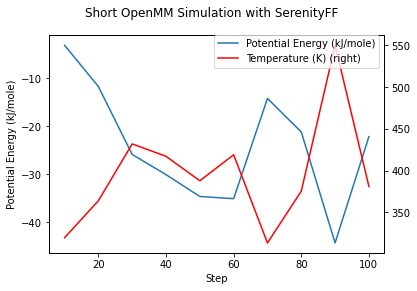

In [16]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_openmm.plot(x='#"Step"', y="Potential Energy (kJ/mole)", ax=ax)
df_openmm.plot(x='#"Step"', y="Temperature (K)", ax=ax1, secondary_y=True, color="red")
ax.set_ylabel("Potential Energy (kJ/mole)")
ax1.set_ylabel("Temperature (K)")
ax.set_xlabel("Step")
fig.suptitle("Short OpenMM Simulation with SerenityFF")
ax.legend().remove()
ax1.legend().remove()
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.show()

In [17]:
os.remove("./example_openmm.csv")

In [18]:
ff.get_partial_charges(molecule=Molecule.from_smiles("CCO"))

<class 'openff.toolkit.topology.topology.TopologyMolecule'>
Assigned partial charges: [-0.43690933  0.04508183 -0.67652615  0.13167229  0.13167229  0.13167229
  0.10377626  0.10377626  0.46578425] e


Quantity(value=array([-0.43690933,  0.04508183, -0.67652615,  0.13167229,  0.13167229,
        0.13167229,  0.10377626,  0.10377626,  0.46578425]), unit=elementary charge)